## Library Imports

In [2]:
import modin.pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings 
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

import joblib

## Global Variables

In [3]:
interval = '1d' # time gap between data points
history = 'max' # time history going back...
perc_inc = 0.02 # 2% increase within time interval
symbol = 'IYW' # IYW iShares Tech ETF

## Yahoo Finance

In [4]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = True
                      )

[*********************100%***********************]  1 of 1 completed


In [8]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-29,260.859985,264.450012,257.890015,264.450012,264.450012,103100
2020-06-30,264.369995,270.239990,264.200012,269.799988,269.799988,158800
2020-07-01,269.720001,272.149994,268.799988,270.839996,270.839996,96700
2020-07-02,273.510010,274.339996,271.809998,272.119995,272.119995,93100
2020-07-06,275.570007,278.769989,275.570007,277.519989,277.519989,268700


## Create Precent Change

In [9]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Date,,,,,,,
2020-06-29,260.859985,264.450012,257.890015,264.450012,264.450012,103100,0.013762
2020-06-30,264.369995,270.239990,264.200012,269.799988,269.799988,158800,0.020539
2020-07-01,269.720001,272.149994,268.799988,270.839996,270.839996,96700,0.004152
2020-07-02,273.510010,274.339996,271.809998,272.119995,272.119995,93100,-0.005082
2020-07-06,275.570007,278.769989,275.570007,277.519989,277.519989,268700,0.007076


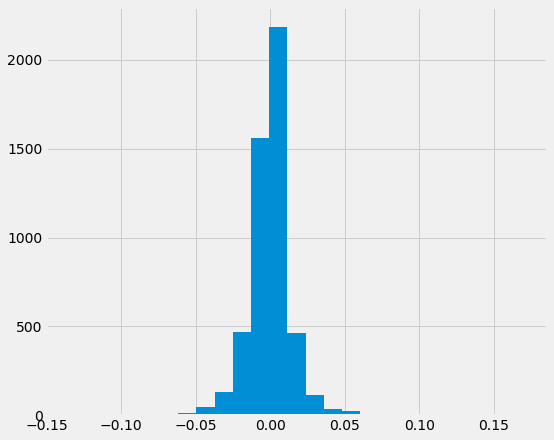

In [11]:
stock_df['Percent Change'].hist(bins=25);

In [13]:
stock_df['Percent Change'].quantile([0.97]) # 2 stdev above average % change

0.97    0.026324
Name: Percent Change, dtype: float64

## Assign Direction

In [14]:
stock_df['Direction'] = np.where(stock_df['Percent Change'] > perc_inc
                                 , 1
                                 , 0
                                )
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Date,,,,,,,,
2020-06-29,260.859985,264.450012,257.890015,264.450012,264.450012,103100,0.013762,0
2020-06-30,264.369995,270.239990,264.200012,269.799988,269.799988,158800,0.020539,1
2020-07-01,269.720001,272.149994,268.799988,270.839996,270.839996,96700,0.004152,0
2020-07-02,273.510010,274.339996,271.809998,272.119995,272.119995,93100,-0.005082,0
2020-07-06,275.570007,278.769989,275.570007,277.519989,277.519989,268700,0.007076,0


## Shift Direction Column Up by 1

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [15]:
dir_vals = stock_df.Direction.values
print(f'Length Before: {len(dir_vals)}')
dir_vals = dir_vals[1:len(dir_vals)]
print(f'Length After: {len(dir_vals)}')

Length Before: 5063
Length After: 5062
